In [1]:
!pip install keras

    100% |████████████████████████████████| 337kB 2.7MB/s ta 0:00:01
    100% |████████████████████████████████| 256kB 3.0MB/s ta 0:00:01
    100% |████████████████████████████████| 46.7MB 25kB/s  eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /home/aladetan/.cache/pip/wheels/03/05/65/bdc14f2c6e09e82ae3e0f13d021e1b6b2481437ea2f207df3f
Successfully built pyyaml
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [158]:
!pip install scikit-learn

    100% |████████████████████████████████| 12.2MB 87kB/s  eta 0:00:01
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [29]:
!pip3 install tensorflowjs

  Using cached https://files.pythonhosted.org/packages/86/45/a273fe3f8fe931a11da34fba1cb74013cfc70dcf93e5d8d329c951dc44c5/Keras-2.1.4-py2.py3-none-any.whl
    100% |████████████████████████████████| 12.1MB 114kB/s eta 0:00:01
    100% |████████████████████████████████| 5.3MB 285kB/s eta 0:00:01    19% |██████▎                         | 1.0MB 38.6MB/s eta 0:00:01
    100% |████████████████████████████████| 48.0MB 30kB/s  eta 0:00:01
    100% |████████████████████████████████| 49.7MB 25kB/s  eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/4a/85/db5a2df477072b2902b0eb892feb37d88ac635d36245a72a6a69b23b383a/PyYAML-3.12.tar.gz
    100% |████████████████████████████████| 6.4MB 231kB/s eta 0:00:01   8% |██▊                             | 542kB 46.9MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 7.5MB/s eta 0:00:01
    100% |████████████████████████████████| 8.8MB 162kB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 8.6MB/s eta 0:00:01
    100

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import spotipy
from spotipy import util
from config import config

In [4]:
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id=config['spotify_id'], client_secret=config['spotify_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Quick tools

### check # of (all) labelled songs and features

In [5]:
l = pd.read_json('labelled', orient='rows')
f  = pd.read_json('features')
print(l.shape[1])
print(f.shape[0])
print l.shape[1] == f.shape[0]

1270
1270
True


## Data Collection

Features are already downloaded to save time/bandwith, but will continue to recollect data in notebook until data is too big/labelling is done

In [6]:
labelled = json.load(open('labelled'))

In [7]:
def mood_encode(moods):
    values = {'chill':0, 'hype':2, 'happy':0, 'sad':1}
#     chill happy 0
#     chill sad 1
#     hype happy 2
#     hype sad 3
    output = 0
    for mood in moods:
        output += values[mood]
        
    return output

In [8]:
sample = []
for row in labelled:
    label = mood_encode(labelled[row]['mood'])
    sample.append([row,labelled[row]['name'],label])
songs = pd.DataFrame(sample, columns=['id','title','label']).set_index('id')
songs.head()

,title,label
id,,
3KNlsVwlMjjKn1g2tTmiIe,She Said,2
72X7mJmnx6pHyRWvtelVkL,Safe,2
6BbINUfGabVyiNFJpQXn3x,Wicked,2
3s2eG9xSDGyd705tT0hD43,Magic City,2
2ImWMn8Pqxa8gHfk1ZJvAh,Use My Heart,1


In [9]:
features = pd.read_json('features').drop(columns=['analysis_url','track_href','uri','type']).set_index('id')
features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,
4l94386YhnCzduk44xzFRx,0.00594,0.547,170960,0.848,0.000000,2,0.0743,-5.622,1,0.0680,128.987,4,0.393
07RULM1xjoEaal27GAsioi,0.21500,0.602,230027,0.678,0.000000,7,0.1150,-6.946,1,0.0300,95.496,4,0.922
1FvU97lrWOG2NRxErh6OZz,0.06330,0.897,334467,0.661,0.000000,8,0.1160,-6.200,0,0.2700,127.081,4,0.193
4XYOnP0tFe8ifE3hHitQBF,0.66700,0.528,189240,0.288,0.000000,0,0.1130,-8.608,0,0.0262,95.389,4,0.294
5NGcTyu5c4o5OQN2qDHMuq,0.32100,0.668,183053,0.759,0.000001,9,0.1470,-6.394,1,0.1380,198.052,4,0.925


In [10]:
data = songs.join(features)
data.head()

,title,label,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,,,
3KNlsVwlMjjKn1g2tTmiIe,She Said,2,0.00030,0.418,224640,0.945,0.00000,7,0.1060,-3.757,1,0.0683,165.041,4,0.693
72X7mJmnx6pHyRWvtelVkL,Safe,2,0.13800,0.691,185822,0.798,0.00000,9,0.3040,-4.493,1,0.0360,102.031,4,0.905
6BbINUfGabVyiNFJpQXn3x,Wicked,2,0.00191,0.718,173347,0.679,0.01040,11,0.3850,-5.899,0,0.0706,157.970,4,0.205
3s2eG9xSDGyd705tT0hD43,Magic City,2,0.08410,0.757,175238,0.867,0.09920,0,0.1250,-2.529,0,0.0362,125.962,4,0.499
2ImWMn8Pqxa8gHfk1ZJvAh,Use My Heart,1,0.20900,0.361,230253,0.658,0.00456,9,0.0887,-9.365,1,0.0400,82.979,4,0.169


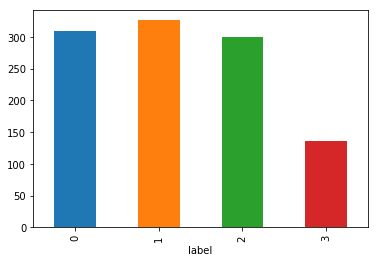

In [12]:
data.groupby(['label']).title.count().plot(kind='bar')

In [11]:
#trying to remove some 3 to compensate
three_rows = data.loc[data['label'] == 2]
drop_indices = np.random.choice(three_rows.index, 200, replace=False)
data = data.drop(drop_indices)

## First NN Attempt

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras.models import load_model

/home/aladetan/.pyenv/versions/2.7.14/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
np.random.seed(7)

Need to reshape df to numpy array for keras

In [15]:
array = np.float32(data.drop(columns=['title','instrumentalness','duration_ms','time_signature']).values)
x = array[:,1:]
y = array[:,0]
y_cat = np_utils.to_categorical(y)
dimension = x.shape[1]
print(dimension)
print(y)
print(y_cat)

10
[2. 2. 1. ... 1. 1. 2.]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


### Model

In [16]:
model = Sequential()
model.add(Dense(10, input_dim=dimension, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(4, activation='softmax'))

Need to learn why sigmoid activation function worked vs. relu function

In [ ]:
# model = Sequential()
# model.add(Dense(10, input_dim=dimension, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(6, activation='relu'))
# model.add(Dense(4, activation='softmax'))

### Compiling

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit

In [18]:
model.fit(x, y_cat, epochs=5000, batch_size=30)

Epoch 1/5000
1070/1070 [==============================] - 0s 440us/step - loss: 1.4031 - acc: 0.2888
Epoch 2/5000
1070/1070 [==============================] - 0s 78us/step - loss: 1.3683 - acc: 0.2888
Epoch 3/5000
1070/1070 [==============================] - 0s 68us/step - loss: 1.3516 - acc: 0.2888
Epoch 4/5000
1070/1070 [==============================] - 0s 76us/step - loss: 1.3442 - acc: 0.2935
Epoch 5/5000
1070/1070 [==============================] - 0s 90us/step - loss: 1.3407 - acc: 0.2766
Epoch 6/5000
1070/1070 [==============================] - 0s 80us/step - loss: 1.3382 - acc: 0.3150
Epoch 7/5000
1070/1070 [==============================] - 0s 73us/step - loss: 1.3372 - acc: 0.3346
Epoch 8/5000
1070/1070 [==============================] - 0s 65us/step - loss: 1.3356 - acc: 0.3318
Epoch 9/5000
1070/1070 [==============================] - 0s 77us/step - loss: 1.3346 - acc: 0.3271
Epoch 10/5000
1070/1070 [==============================] - 0s 68us/step - loss: 1.3342 - acc: 0.288

1070/1070 [==============================] - 0s 60us/step - loss: 1.0730 - acc: 0.4776
Epoch 83/5000
1070/1070 [==============================] - 0s 69us/step - loss: 1.0809 - acc: 0.4748
Epoch 84/5000
1070/1070 [==============================] - 0s 55us/step - loss: 1.0702 - acc: 0.4841
Epoch 85/5000
1070/1070 [==============================] - 0s 70us/step - loss: 1.0713 - acc: 0.4692
Epoch 86/5000
1070/1070 [==============================] - 0s 82us/step - loss: 1.0813 - acc: 0.4664
Epoch 87/5000
1070/1070 [==============================] - 0s 78us/step - loss: 1.0700 - acc: 0.4822
Epoch 88/5000
1070/1070 [==============================] - 0s 80us/step - loss: 1.0701 - acc: 0.4785
Epoch 89/5000
1070/1070 [==============================] - 0s 84us/step - loss: 1.0742 - acc: 0.4794
Epoch 90/5000
1070/1070 [==============================] - 0s 57us/step - loss: 1.0731 - acc: 0.4701
Epoch 91/5000
1070/1070 [==============================] - 0s 58us/step - loss: 1.0724 - acc: 0.4785
Epoc

1070/1070 [==============================] - 0s 68us/step - loss: 1.0484 - acc: 0.4720
Epoch 163/5000
1070/1070 [==============================] - 0s 65us/step - loss: 1.0437 - acc: 0.4757
Epoch 164/5000
1070/1070 [==============================] - 0s 63us/step - loss: 1.0434 - acc: 0.4720
Epoch 165/5000
1070/1070 [==============================] - 0s 57us/step - loss: 1.0431 - acc: 0.4757
Epoch 166/5000
1070/1070 [==============================] - 0s 58us/step - loss: 1.0485 - acc: 0.4841
Epoch 167/5000
1070/1070 [==============================] - 0s 62us/step - loss: 1.0444 - acc: 0.4860
Epoch 168/5000
1070/1070 [==============================] - 0s 53us/step - loss: 1.0445 - acc: 0.4785
Epoch 169/5000
1070/1070 [==============================] - 0s 64us/step - loss: 1.0469 - acc: 0.4738
Epoch 170/5000
1070/1070 [==============================] - 0s 70us/step - loss: 1.0406 - acc: 0.4729
Epoch 171/5000
1070/1070 [==============================] - 0s 97us/step - loss: 1.0444 - acc: 0.

1070/1070 [==============================] - 0s 59us/step - loss: 1.0314 - acc: 0.4841
Epoch 243/5000
1070/1070 [==============================] - 0s 48us/step - loss: 1.0291 - acc: 0.4654
Epoch 244/5000
1070/1070 [==============================] - 0s 84us/step - loss: 1.0302 - acc: 0.4822
Epoch 245/5000
1070/1070 [==============================] - 0s 96us/step - loss: 1.0292 - acc: 0.4841
Epoch 246/5000
1070/1070 [==============================] - 0s 118us/step - loss: 1.0328 - acc: 0.4860
Epoch 247/5000
1070/1070 [==============================] - 0s 67us/step - loss: 1.0380 - acc: 0.4766
Epoch 248/5000
1070/1070 [==============================] - 0s 64us/step - loss: 1.0286 - acc: 0.4822
Epoch 249/5000
1070/1070 [==============================] - 0s 72us/step - loss: 1.0290 - acc: 0.4813
Epoch 250/5000
1070/1070 [==============================] - 0s 82us/step - loss: 1.0300 - acc: 0.4822
Epoch 251/5000
1070/1070 [==============================] - 0s 74us/step - loss: 1.0235 - acc: 0

1070/1070 [==============================] - 0s 49us/step - loss: 1.0205 - acc: 0.4888
Epoch 323/5000
1070/1070 [==============================] - 0s 64us/step - loss: 1.0185 - acc: 0.4860
Epoch 324/5000
1070/1070 [==============================] - 0s 75us/step - loss: 1.0182 - acc: 0.4897
Epoch 325/5000
1070/1070 [==============================] - 0s 74us/step - loss: 1.0169 - acc: 0.4888
Epoch 326/5000
1070/1070 [==============================] - 0s 48us/step - loss: 1.0315 - acc: 0.4813
Epoch 327/5000
1070/1070 [==============================] - 0s 56us/step - loss: 1.0183 - acc: 0.4972
Epoch 328/5000
1070/1070 [==============================] - 0s 58us/step - loss: 1.0261 - acc: 0.5009
Epoch 329/5000
1070/1070 [==============================] - 0s 78us/step - loss: 1.0199 - acc: 0.4897
Epoch 330/5000
1070/1070 [==============================] - 0s 49us/step - loss: 1.0197 - acc: 0.4785
Epoch 331/5000
1070/1070 [==============================] - 0s 47us/step - loss: 1.0211 - acc: 0.

1070/1070 [==============================] - 0s 115us/step - loss: 1.0088 - acc: 0.5037
Epoch 403/5000
1070/1070 [==============================] - 0s 139us/step - loss: 1.0118 - acc: 0.4972
Epoch 404/5000
1070/1070 [==============================] - 0s 115us/step - loss: 1.0087 - acc: 0.5009
Epoch 405/5000
1070/1070 [==============================] - 0s 87us/step - loss: 1.0109 - acc: 0.5009
Epoch 406/5000
1070/1070 [==============================] - 0s 73us/step - loss: 1.0108 - acc: 0.4981
Epoch 407/5000
1070/1070 [==============================] - 0s 78us/step - loss: 1.0131 - acc: 0.4944
Epoch 408/5000
1070/1070 [==============================] - 0s 71us/step - loss: 1.0105 - acc: 0.5112
Epoch 409/5000
1070/1070 [==============================] - 0s 59us/step - loss: 1.0120 - acc: 0.4944
Epoch 410/5000
1070/1070 [==============================] - 0s 61us/step - loss: 1.0187 - acc: 0.4981
Epoch 411/5000
1070/1070 [==============================] - 0s 53us/step - loss: 1.0212 - acc:

1070/1070 [==============================] - 0s 49us/step - loss: 1.0033 - acc: 0.5084
Epoch 483/5000
1070/1070 [==============================] - 0s 50us/step - loss: 1.0025 - acc: 0.5056
Epoch 484/5000
1070/1070 [==============================] - 0s 47us/step - loss: 1.0029 - acc: 0.5131
Epoch 485/5000
1070/1070 [==============================] - 0s 47us/step - loss: 1.0008 - acc: 0.5103
Epoch 486/5000
1070/1070 [==============================] - 0s 49us/step - loss: 1.0010 - acc: 0.5075
Epoch 487/5000
1070/1070 [==============================] - 0s 48us/step - loss: 1.0089 - acc: 0.5121
Epoch 488/5000
1070/1070 [==============================] - 0s 47us/step - loss: 1.0038 - acc: 0.5075
Epoch 489/5000
1070/1070 [==============================] - 0s 47us/step - loss: 1.0013 - acc: 0.5084
Epoch 490/5000
1070/1070 [==============================] - 0s 49us/step - loss: 1.0094 - acc: 0.5150
Epoch 491/5000
1070/1070 [==============================] - 0s 48us/step - loss: 1.0014 - acc: 0.

1070/1070 [==============================] - 0s 50us/step - loss: 0.9923 - acc: 0.5243
Epoch 563/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9935 - acc: 0.5168
Epoch 564/5000
1070/1070 [==============================] - 0s 51us/step - loss: 0.9998 - acc: 0.5206
Epoch 565/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.9965 - acc: 0.5196
Epoch 566/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.9942 - acc: 0.5140
Epoch 567/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9930 - acc: 0.5159
Epoch 568/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9917 - acc: 0.5206
Epoch 569/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9975 - acc: 0.5178
Epoch 570/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.9960 - acc: 0.5215
Epoch 571/5000
1070/1070 [==============================] - 0s 74us/step - loss: 1.0020 - acc: 0.

1070/1070 [==============================] - 0s 69us/step - loss: 0.9884 - acc: 0.5206
Epoch 643/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.9891 - acc: 0.5271
Epoch 644/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.9802 - acc: 0.5280
Epoch 645/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.9825 - acc: 0.5103
Epoch 646/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.9844 - acc: 0.5243
Epoch 647/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9898 - acc: 0.5196
Epoch 648/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9867 - acc: 0.5215
Epoch 649/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9847 - acc: 0.5206
Epoch 650/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9842 - acc: 0.5308
Epoch 651/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9844 - acc: 0.

1070/1070 [==============================] - 0s 49us/step - loss: 0.9782 - acc: 0.5206
Epoch 723/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9777 - acc: 0.5252
Epoch 724/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9713 - acc: 0.5243
Epoch 725/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9736 - acc: 0.5224
Epoch 726/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9756 - acc: 0.5327
Epoch 727/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.9732 - acc: 0.5308
Epoch 728/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.9718 - acc: 0.5318
Epoch 729/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9711 - acc: 0.5308
Epoch 730/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9713 - acc: 0.5280
Epoch 731/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.9770 - acc: 0.

1070/1070 [==============================] - 0s 58us/step - loss: 0.9641 - acc: 0.5243
Epoch 803/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.9723 - acc: 0.5252
Epoch 804/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9623 - acc: 0.5346
Epoch 805/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9732 - acc: 0.5290
Epoch 806/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9661 - acc: 0.5346
Epoch 807/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.9631 - acc: 0.5336
Epoch 808/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9687 - acc: 0.5215
Epoch 809/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9624 - acc: 0.5327
Epoch 810/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9705 - acc: 0.5299
Epoch 811/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9642 - acc: 0.

1070/1070 [==============================] - 0s 54us/step - loss: 0.9571 - acc: 0.5654
Epoch 883/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9596 - acc: 0.5570
Epoch 884/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9594 - acc: 0.5645
Epoch 885/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9559 - acc: 0.5607
Epoch 886/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9638 - acc: 0.5570
Epoch 887/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9593 - acc: 0.5626
Epoch 888/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9588 - acc: 0.5542
Epoch 889/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9565 - acc: 0.5617
Epoch 890/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.9593 - acc: 0.5598
Epoch 891/5000
1070/1070 [==============================] - 0s 67us/step - loss: 0.9581 - acc: 0.

1070/1070 [==============================] - 0s 66us/step - loss: 0.9493 - acc: 0.5701
Epoch 963/5000
1070/1070 [==============================] - 0s 77us/step - loss: 0.9495 - acc: 0.5748
Epoch 964/5000
1070/1070 [==============================] - 0s 78us/step - loss: 0.9553 - acc: 0.5626
Epoch 965/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9526 - acc: 0.5654
Epoch 966/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9467 - acc: 0.5673
Epoch 967/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.9481 - acc: 0.5785
Epoch 968/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.9464 - acc: 0.5682
Epoch 969/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9446 - acc: 0.5645
Epoch 970/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9548 - acc: 0.5626
Epoch 971/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9500 - acc: 0.

1070/1070 [==============================] - 0s 47us/step - loss: 0.9488 - acc: 0.5645
Epoch 1043/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9424 - acc: 0.5776
Epoch 1044/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.9459 - acc: 0.5757
Epoch 1045/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9437 - acc: 0.5701
Epoch 1046/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9481 - acc: 0.5636
Epoch 1047/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9420 - acc: 0.5701
Epoch 1048/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9492 - acc: 0.5710
Epoch 1049/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9420 - acc: 0.5794
Epoch 1050/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.9416 - acc: 0.5794
Epoch 1051/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.9428 

1070/1070 [==============================] - 0s 55us/step - loss: 0.9385 - acc: 0.5822
Epoch 1122/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.9367 - acc: 0.5832
Epoch 1123/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.9385 - acc: 0.5720
Epoch 1124/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9373 - acc: 0.5748
Epoch 1125/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9401 - acc: 0.5673
Epoch 1126/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9385 - acc: 0.5720
Epoch 1127/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9383 - acc: 0.5720
Epoch 1128/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9380 - acc: 0.5813
Epoch 1129/5000
1070/1070 [==============================] - 0s 65us/step - loss: 0.9426 - acc: 0.5738
Epoch 1130/5000
1070/1070 [==============================] - 0s 74us/step - loss: 0.9429 

1070/1070 [==============================] - 0s 50us/step - loss: 0.9404 - acc: 0.5860
Epoch 1201/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.9525 - acc: 0.5748
Epoch 1202/5000
1070/1070 [==============================] - 0s 70us/step - loss: 0.9354 - acc: 0.5832
Epoch 1203/5000
1070/1070 [==============================] - 0s 71us/step - loss: 0.9325 - acc: 0.5832
Epoch 1204/5000
1070/1070 [==============================] - 0s 71us/step - loss: 0.9358 - acc: 0.5804
Epoch 1205/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.9330 - acc: 0.5832
Epoch 1206/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.9323 - acc: 0.5897
Epoch 1207/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9334 - acc: 0.5748
Epoch 1208/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9349 - acc: 0.5776
Epoch 1209/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9322 

1070/1070 [==============================] - 0s 75us/step - loss: 0.9355 - acc: 0.5822
Epoch 1280/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.9295 - acc: 0.5729
Epoch 1281/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9293 - acc: 0.5785
Epoch 1282/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.9348 - acc: 0.5794
Epoch 1283/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9364 - acc: 0.5645
Epoch 1284/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.9242 - acc: 0.5916
Epoch 1285/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9274 - acc: 0.5785
Epoch 1286/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9327 - acc: 0.5860
Epoch 1287/5000
1070/1070 [==============================] - 0s 51us/step - loss: 0.9352 - acc: 0.5822
Epoch 1288/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9416 

1070/1070 [==============================] - 0s 49us/step - loss: 0.9266 - acc: 0.5860
Epoch 1359/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9258 - acc: 0.5776
Epoch 1360/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9246 - acc: 0.5822
Epoch 1361/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9329 - acc: 0.5785
Epoch 1362/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9278 - acc: 0.5888
Epoch 1363/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9255 - acc: 0.5785
Epoch 1364/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9289 - acc: 0.5869
Epoch 1365/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9292 - acc: 0.5813
Epoch 1366/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9256 - acc: 0.5850
Epoch 1367/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9292 

1070/1070 [==============================] - 0s 48us/step - loss: 0.9196 - acc: 0.5860
Epoch 1438/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9260 - acc: 0.5888
Epoch 1439/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9230 - acc: 0.5850
Epoch 1440/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9207 - acc: 0.5888
Epoch 1441/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9216 - acc: 0.5860
Epoch 1442/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9244 - acc: 0.5888
Epoch 1443/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.9203 - acc: 0.6000
Epoch 1444/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9210 - acc: 0.5813
Epoch 1445/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9260 - acc: 0.5822
Epoch 1446/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.9181 

1070/1070 [==============================] - 0s 48us/step - loss: 0.9184 - acc: 0.5953
Epoch 1517/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9167 - acc: 0.5963
Epoch 1518/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.9150 - acc: 0.5850
Epoch 1519/5000
1070/1070 [==============================] - 0s 99us/step - loss: 0.9182 - acc: 0.5916
Epoch 1520/5000
1070/1070 [==============================] - 0s 84us/step - loss: 0.9170 - acc: 0.5935
Epoch 1521/5000
1070/1070 [==============================] - 0s 84us/step - loss: 0.9223 - acc: 0.5804
Epoch 1522/5000
1070/1070 [==============================] - 0s 79us/step - loss: 0.9153 - acc: 0.5953
Epoch 1523/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9283 - acc: 0.5850
Epoch 1524/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9301 - acc: 0.5841
Epoch 1525/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9247 

1070/1070 [==============================] - 0s 48us/step - loss: 0.9177 - acc: 0.5991
Epoch 1596/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9153 - acc: 0.5916
Epoch 1597/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9144 - acc: 0.5935
Epoch 1598/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9133 - acc: 0.5925
Epoch 1599/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9143 - acc: 0.5953
Epoch 1600/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9141 - acc: 0.5944
Epoch 1601/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9178 - acc: 0.5897
Epoch 1602/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9215 - acc: 0.5963
Epoch 1603/5000
1070/1070 [==============================] - 0s 46us/step - loss: 0.9133 - acc: 0.5963
Epoch 1604/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9150 

1070/1070 [==============================] - 0s 48us/step - loss: 0.9137 - acc: 0.5953
Epoch 1675/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.9218 - acc: 0.5972
Epoch 1676/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9139 - acc: 0.5972
Epoch 1677/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9135 - acc: 0.6019
Epoch 1678/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.9232 - acc: 0.5935
Epoch 1679/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.9103 - acc: 0.5879
Epoch 1680/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9112 - acc: 0.5991
Epoch 1681/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9135 - acc: 0.5963
Epoch 1682/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9157 - acc: 0.5953
Epoch 1683/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.9123 

1070/1070 [==============================] - 0s 49us/step - loss: 0.9177 - acc: 0.5944
Epoch 1754/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9116 - acc: 0.5925
Epoch 1755/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9152 - acc: 0.5897
Epoch 1756/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9082 - acc: 0.5991
Epoch 1757/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9147 - acc: 0.5879
Epoch 1758/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9135 - acc: 0.6000
Epoch 1759/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9167 - acc: 0.5925
Epoch 1760/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9111 - acc: 0.6019
Epoch 1761/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9075 - acc: 0.6075
Epoch 1762/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9071 

1070/1070 [==============================] - 0s 48us/step - loss: 0.9051 - acc: 0.6056
Epoch 1833/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9125 - acc: 0.5991
Epoch 1834/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9095 - acc: 0.5991
Epoch 1835/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.9139 - acc: 0.6056
Epoch 1836/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9185 - acc: 0.5991
Epoch 1837/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9072 - acc: 0.6103
Epoch 1838/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9050 - acc: 0.6121
Epoch 1839/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9101 - acc: 0.5907
Epoch 1840/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9085 - acc: 0.6009
Epoch 1841/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.9065 

1070/1070 [==============================] - 0s 48us/step - loss: 0.8998 - acc: 0.6140
Epoch 1912/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9096 - acc: 0.6056
Epoch 1913/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9047 - acc: 0.6056
Epoch 1914/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9081 - acc: 0.6000
Epoch 1915/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9063 - acc: 0.5981
Epoch 1916/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9077 - acc: 0.6037
Epoch 1917/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9044 - acc: 0.6019
Epoch 1918/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.9048 - acc: 0.6065
Epoch 1919/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9107 - acc: 0.6037
Epoch 1920/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9035 

1070/1070 [==============================] - 0s 48us/step - loss: 0.9037 - acc: 0.6056
Epoch 1991/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8995 - acc: 0.6140
Epoch 1992/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9191 - acc: 0.5916
Epoch 1993/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9018 - acc: 0.6047
Epoch 1994/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9064 - acc: 0.6131
Epoch 1995/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9000 - acc: 0.6140
Epoch 1996/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9101 - acc: 0.6000
Epoch 1997/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9031 - acc: 0.6112
Epoch 1998/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9007 - acc: 0.6131
Epoch 1999/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9024 

1070/1070 [==============================] - 0s 56us/step - loss: 0.8979 - acc: 0.6121
Epoch 2070/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.9016 - acc: 0.6047
Epoch 2071/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8998 - acc: 0.6215
Epoch 2072/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.9078 - acc: 0.6019
Epoch 2073/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.9024 - acc: 0.6215
Epoch 2074/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8989 - acc: 0.6206
Epoch 2075/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.9014 - acc: 0.6168
Epoch 2076/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.9004 - acc: 0.6103
Epoch 2077/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8987 - acc: 0.6121
Epoch 2078/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8981 

1070/1070 [==============================] - 0s 46us/step - loss: 0.9018 - acc: 0.6206
Epoch 2149/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8977 - acc: 0.6187
Epoch 2150/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9031 - acc: 0.6168
Epoch 2151/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.8970 - acc: 0.6187
Epoch 2152/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9000 - acc: 0.6131
Epoch 2153/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8970 - acc: 0.6196
Epoch 2154/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9052 - acc: 0.6178
Epoch 2155/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9071 - acc: 0.6131
Epoch 2156/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.9002 - acc: 0.6065
Epoch 2157/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9061 

1070/1070 [==============================] - 0s 48us/step - loss: 0.8961 - acc: 0.6178
Epoch 2228/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8990 - acc: 0.6243
Epoch 2229/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9026 - acc: 0.6140
Epoch 2230/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9006 - acc: 0.6187
Epoch 2231/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9006 - acc: 0.6121
Epoch 2232/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9016 - acc: 0.6168
Epoch 2233/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9010 - acc: 0.6047
Epoch 2234/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.8982 - acc: 0.6196
Epoch 2235/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.9045 - acc: 0.6196
Epoch 2236/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8980 

1070/1070 [==============================] - 0s 57us/step - loss: 0.9013 - acc: 0.6168
Epoch 2307/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8959 - acc: 0.6168
Epoch 2308/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.9005 - acc: 0.6196
Epoch 2309/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.8981 - acc: 0.6140
Epoch 2310/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8966 - acc: 0.6150
Epoch 2311/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8971 - acc: 0.6168
Epoch 2312/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8975 - acc: 0.6187
Epoch 2313/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8962 - acc: 0.6131
Epoch 2314/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8938 - acc: 0.6271
Epoch 2315/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8930 

1070/1070 [==============================] - 0s 47us/step - loss: 0.9014 - acc: 0.6121
Epoch 2386/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8931 - acc: 0.6159
Epoch 2387/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8958 - acc: 0.6168
Epoch 2388/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8959 - acc: 0.6234
Epoch 2389/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8922 - acc: 0.6215
Epoch 2390/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8953 - acc: 0.6215
Epoch 2391/5000
1070/1070 [==============================] - 0s 52us/step - loss: 0.8937 - acc: 0.6206
Epoch 2392/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8956 - acc: 0.6178
Epoch 2393/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8951 - acc: 0.6103
Epoch 2394/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8958 

1070/1070 [==============================] - 0s 48us/step - loss: 0.8967 - acc: 0.6112
Epoch 2465/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8902 - acc: 0.6243
Epoch 2466/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9016 - acc: 0.6159
Epoch 2467/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8938 - acc: 0.6187
Epoch 2468/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8974 - acc: 0.6206
Epoch 2469/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8948 - acc: 0.6168
Epoch 2470/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.8929 - acc: 0.6215
Epoch 2471/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.8980 - acc: 0.6206
Epoch 2472/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8944 - acc: 0.6215
Epoch 2473/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8941 

1070/1070 [==============================] - 0s 48us/step - loss: 0.8960 - acc: 0.6243
Epoch 2544/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8952 - acc: 0.6308
Epoch 2545/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9036 - acc: 0.6168
Epoch 2546/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8964 - acc: 0.6178
Epoch 2547/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8923 - acc: 0.6178
Epoch 2548/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9116 - acc: 0.6196
Epoch 2549/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8966 - acc: 0.6084
Epoch 2550/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8890 - acc: 0.6206
Epoch 2551/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8894 - acc: 0.6178
Epoch 2552/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8941 

1070/1070 [==============================] - 0s 60us/step - loss: 0.8896 - acc: 0.6271
Epoch 2623/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8956 - acc: 0.6140
Epoch 2624/5000
1070/1070 [==============================] - 0s 73us/step - loss: 0.8980 - acc: 0.6121
Epoch 2625/5000
1070/1070 [==============================] - 0s 68us/step - loss: 0.8878 - acc: 0.6112
Epoch 2626/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8904 - acc: 0.6150
Epoch 2627/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8956 - acc: 0.6187
Epoch 2628/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.9004 - acc: 0.6252
Epoch 2629/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8885 - acc: 0.6150
Epoch 2630/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8940 - acc: 0.6093
Epoch 2631/5000
1070/1070 [==============================] - 0s 52us/step - loss: 0.8971 

1070/1070 [==============================] - 0s 49us/step - loss: 0.8903 - acc: 0.6159
Epoch 2702/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8876 - acc: 0.6159
Epoch 2703/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8923 - acc: 0.6234
Epoch 2704/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8926 - acc: 0.6168
Epoch 2705/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8878 - acc: 0.6187
Epoch 2706/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8958 - acc: 0.6206
Epoch 2707/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8886 - acc: 0.6206
Epoch 2708/5000
1070/1070 [==============================] - 0s 46us/step - loss: 0.8931 - acc: 0.6196
Epoch 2709/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8910 - acc: 0.6262
Epoch 2710/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.8895 

1070/1070 [==============================] - 0s 47us/step - loss: 0.8961 - acc: 0.6168
Epoch 2781/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8892 - acc: 0.6206
Epoch 2782/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8893 - acc: 0.6159
Epoch 2783/5000
1070/1070 [==============================] - 0s 51us/step - loss: 0.8959 - acc: 0.6206
Epoch 2784/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8894 - acc: 0.6224
Epoch 2785/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8919 - acc: 0.6178
Epoch 2786/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8875 - acc: 0.6243
Epoch 2787/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8893 - acc: 0.6262
Epoch 2788/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8903 - acc: 0.6290
Epoch 2789/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8901 

1070/1070 [==============================] - 0s 48us/step - loss: 0.8881 - acc: 0.6187
Epoch 2860/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8906 - acc: 0.6224
Epoch 2861/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.8904 - acc: 0.6271
Epoch 2862/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8883 - acc: 0.6196
Epoch 2863/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8886 - acc: 0.6224
Epoch 2864/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8892 - acc: 0.6224
Epoch 2865/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8878 - acc: 0.6196
Epoch 2866/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8948 - acc: 0.6206
Epoch 2867/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8874 - acc: 0.6215
Epoch 2868/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8871 

1070/1070 [==============================] - 0s 57us/step - loss: 0.8895 - acc: 0.6308
Epoch 2939/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8873 - acc: 0.6224
Epoch 2940/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8901 - acc: 0.6252
Epoch 2941/5000
1070/1070 [==============================] - 0s 51us/step - loss: 0.8976 - acc: 0.6187
Epoch 2942/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8880 - acc: 0.6178
Epoch 2943/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.8860 - acc: 0.6290
Epoch 2944/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8896 - acc: 0.6196
Epoch 2945/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8978 - acc: 0.6271
Epoch 2946/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8889 - acc: 0.6206
Epoch 2947/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8898 

1070/1070 [==============================] - 0s 49us/step - loss: 0.8994 - acc: 0.6103
Epoch 3018/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8949 - acc: 0.6178
Epoch 3019/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8888 - acc: 0.6234
Epoch 3020/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.8875 - acc: 0.6206
Epoch 3021/5000
1070/1070 [==============================] - 0s 52us/step - loss: 0.8889 - acc: 0.6280
Epoch 3022/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8878 - acc: 0.6187
Epoch 3023/5000
1070/1070 [==============================] - 0s 48us/step - loss: 0.9043 - acc: 0.6028
Epoch 3024/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8909 - acc: 0.6187
Epoch 3025/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.8905 - acc: 0.6196
Epoch 3026/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8904 

1070/1070 [==============================] - 0s 82us/step - loss: 0.8888 - acc: 0.6262
Epoch 3097/5000
1070/1070 [==============================] - 0s 84us/step - loss: 0.8886 - acc: 0.6178
Epoch 3098/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.9057 - acc: 0.6178
Epoch 3099/5000
1070/1070 [==============================] - 0s 50us/step - loss: 0.8922 - acc: 0.6150
Epoch 3100/5000
1070/1070 [==============================] - 0s 47us/step - loss: 0.8874 - acc: 0.6252
Epoch 3101/5000
1070/1070 [==============================] - 0s 49us/step - loss: 0.8924 - acc: 0.6252
Epoch 3102/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8961 - acc: 0.6168
Epoch 3103/5000
1070/1070 [==============================] - 0s 72us/step - loss: 0.8927 - acc: 0.6084
Epoch 3104/5000
1070/1070 [==============================] - 0s 76us/step - loss: 0.8883 - acc: 0.6187
Epoch 3105/5000
1070/1070 [==============================] - 0s 79us/step - loss: 0.8869 

1070/1070 [==============================] - 0s 63us/step - loss: 0.8854 - acc: 0.6336
Epoch 3176/5000
1070/1070 [==============================] - 0s 67us/step - loss: 0.8875 - acc: 0.6243
Epoch 3177/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8913 - acc: 0.6178
Epoch 3178/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8895 - acc: 0.6168
Epoch 3179/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8862 - acc: 0.6224
Epoch 3180/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8897 - acc: 0.6215
Epoch 3181/5000
1070/1070 [==============================] - 0s 85us/step - loss: 0.8878 - acc: 0.6327
Epoch 3182/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8890 - acc: 0.6187
Epoch 3183/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8940 - acc: 0.6206
Epoch 3184/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.8903 

1070/1070 [==============================] - 0s 60us/step - loss: 0.8916 - acc: 0.6290
Epoch 3255/5000
1070/1070 [==============================] - 0s 65us/step - loss: 0.8907 - acc: 0.6140
Epoch 3256/5000
1070/1070 [==============================] - 0s 70us/step - loss: 0.8893 - acc: 0.6206
Epoch 3257/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.8857 - acc: 0.6243
Epoch 3258/5000
1070/1070 [==============================] - 0s 67us/step - loss: 0.8863 - acc: 0.6206
Epoch 3259/5000
1070/1070 [==============================] - 0s 72us/step - loss: 0.8820 - acc: 0.6262
Epoch 3260/5000
1070/1070 [==============================] - 0s 70us/step - loss: 0.8878 - acc: 0.6206
Epoch 3261/5000
1070/1070 [==============================] - 0s 65us/step - loss: 0.8901 - acc: 0.6121
Epoch 3262/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8982 - acc: 0.6112
Epoch 3263/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8845 

1070/1070 [==============================] - 0s 77us/step - loss: 0.8890 - acc: 0.6243
Epoch 3334/5000
1070/1070 [==============================] - 0s 70us/step - loss: 0.8899 - acc: 0.6150
Epoch 3335/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8834 - acc: 0.6243
Epoch 3336/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8852 - acc: 0.6168
Epoch 3337/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.9040 - acc: 0.6168
Epoch 3338/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8943 - acc: 0.6140
Epoch 3339/5000
1070/1070 [==============================] - 0s 116us/step - loss: 0.8834 - acc: 0.6131
Epoch 3340/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8807 - acc: 0.6280
Epoch 3341/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8891 - acc: 0.6243
Epoch 3342/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8896

1070/1070 [==============================] - 0s 59us/step - loss: 0.8899 - acc: 0.6121
Epoch 3413/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8905 - acc: 0.6131
Epoch 3414/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8883 - acc: 0.6103
Epoch 3415/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8948 - acc: 0.6252
Epoch 3416/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8838 - acc: 0.6252
Epoch 3417/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8845 - acc: 0.6252
Epoch 3418/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8858 - acc: 0.6206
Epoch 3419/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8834 - acc: 0.6318
Epoch 3420/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8826 - acc: 0.6243
Epoch 3421/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8826 

1070/1070 [==============================] - 0s 58us/step - loss: 0.8850 - acc: 0.6234
Epoch 3492/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8857 - acc: 0.6224
Epoch 3493/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8837 - acc: 0.6196
Epoch 3494/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8878 - acc: 0.6196
Epoch 3495/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8882 - acc: 0.6224
Epoch 3496/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8857 - acc: 0.6215
Epoch 3497/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.8862 - acc: 0.6243
Epoch 3498/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8888 - acc: 0.6243
Epoch 3499/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8871 - acc: 0.6150
Epoch 3500/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8878 

1070/1070 [==============================] - 0s 61us/step - loss: 0.8834 - acc: 0.6178
Epoch 3571/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8904 - acc: 0.6215
Epoch 3572/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8924 - acc: 0.6252
Epoch 3573/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8809 - acc: 0.6224
Epoch 3574/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8852 - acc: 0.6252
Epoch 3575/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8845 - acc: 0.6187
Epoch 3576/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8961 - acc: 0.6103
Epoch 3577/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8847 - acc: 0.6168
Epoch 3578/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8858 - acc: 0.6215
Epoch 3579/5000
1070/1070 [==============================] - ETA: 0s - loss: 0.8831 - acc

1070/1070 [==============================] - 0s 56us/step - loss: 0.8832 - acc: 0.6159
Epoch 3650/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8874 - acc: 0.6150
Epoch 3651/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8834 - acc: 0.6150
Epoch 3652/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8873 - acc: 0.6234
Epoch 3653/5000
1070/1070 [==============================] - 0s 52us/step - loss: 0.8838 - acc: 0.6280
Epoch 3654/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8867 - acc: 0.6131
Epoch 3655/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8874 - acc: 0.6121
Epoch 3656/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8840 - acc: 0.6262
Epoch 3657/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8873 - acc: 0.6093
Epoch 3658/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.8830 

1070/1070 [==============================] - 0s 56us/step - loss: 0.8953 - acc: 0.6187
Epoch 3729/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8877 - acc: 0.6308
Epoch 3730/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8939 - acc: 0.6206
Epoch 3731/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8848 - acc: 0.6224
Epoch 3732/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8849 - acc: 0.6224
Epoch 3733/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8848 - acc: 0.6168
Epoch 3734/5000
1070/1070 [==============================] - 0s 65us/step - loss: 0.8842 - acc: 0.6252
Epoch 3735/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8845 - acc: 0.6224
Epoch 3736/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8837 - acc: 0.6178
Epoch 3737/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8832 

1070/1070 [==============================] - 0s 62us/step - loss: 0.8831 - acc: 0.6196
Epoch 3808/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8824 - acc: 0.6252
Epoch 3809/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8871 - acc: 0.6187
Epoch 3810/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8842 - acc: 0.6178
Epoch 3811/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8800 - acc: 0.6131
Epoch 3812/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8830 - acc: 0.6140
Epoch 3813/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8857 - acc: 0.6187
Epoch 3814/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8844 - acc: 0.6131
Epoch 3815/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8828 - acc: 0.6224
Epoch 3816/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8830 

1070/1070 [==============================] - 0s 63us/step - loss: 0.8829 - acc: 0.6243
Epoch 3887/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8839 - acc: 0.6196
Epoch 3888/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8834 - acc: 0.6150
Epoch 3889/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8808 - acc: 0.6318
Epoch 3890/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8811 - acc: 0.6318
Epoch 3891/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8882 - acc: 0.6103
Epoch 3892/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8828 - acc: 0.6299
Epoch 3893/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8842 - acc: 0.6131
Epoch 3894/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8866 - acc: 0.6187
Epoch 3895/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8777 

1070/1070 [==============================] - 0s 63us/step - loss: 0.8911 - acc: 0.6103
Epoch 3966/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8897 - acc: 0.6131
Epoch 3967/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8785 - acc: 0.6308
Epoch 3968/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8880 - acc: 0.6065
Epoch 3969/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8809 - acc: 0.6140
Epoch 3970/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.8843 - acc: 0.6196
Epoch 3971/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8868 - acc: 0.6234
Epoch 3972/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8810 - acc: 0.6215
Epoch 3973/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8819 - acc: 0.6290
Epoch 3974/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8811 

1070/1070 [==============================] - 0s 64us/step - loss: 0.8854 - acc: 0.6215
Epoch 4045/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8822 - acc: 0.6159
Epoch 4046/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8852 - acc: 0.6243
Epoch 4047/5000
1070/1070 [==============================] - 0s 68us/step - loss: 0.8982 - acc: 0.6093
Epoch 4048/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8846 - acc: 0.6187
Epoch 4049/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8819 - acc: 0.6280
Epoch 4050/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8825 - acc: 0.6234
Epoch 4051/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8838 - acc: 0.6196
Epoch 4052/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8822 - acc: 0.6168
Epoch 4053/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8808 

1070/1070 [==============================] - 0s 59us/step - loss: 0.8820 - acc: 0.6178
Epoch 4124/5000
1070/1070 [==============================] - 0s 67us/step - loss: 0.8820 - acc: 0.6262
Epoch 4125/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8817 - acc: 0.6084
Epoch 4126/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8959 - acc: 0.6252
Epoch 4127/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8822 - acc: 0.6215
Epoch 4128/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8828 - acc: 0.6150
Epoch 4129/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.8864 - acc: 0.6234
Epoch 4130/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8978 - acc: 0.6093
Epoch 4131/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8825 - acc: 0.6271
Epoch 4132/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8844 

1070/1070 [==============================] - 0s 52us/step - loss: 0.8805 - acc: 0.6252
Epoch 4203/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8771 - acc: 0.6318
Epoch 4204/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8860 - acc: 0.6243
Epoch 4205/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8844 - acc: 0.6290
Epoch 4206/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8817 - acc: 0.6308
Epoch 4207/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8818 - acc: 0.6224
Epoch 4208/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8833 - acc: 0.6243
Epoch 4209/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8808 - acc: 0.6318
Epoch 4210/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8839 - acc: 0.6327
Epoch 4211/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8837 

1070/1070 [==============================] - 0s 62us/step - loss: 0.8802 - acc: 0.6336
Epoch 4282/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8855 - acc: 0.6121
Epoch 4283/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8874 - acc: 0.6243
Epoch 4284/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8839 - acc: 0.6243
Epoch 4285/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8896 - acc: 0.6271
Epoch 4286/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8821 - acc: 0.6103
Epoch 4287/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8824 - acc: 0.6318
Epoch 4288/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8809 - acc: 0.6318
Epoch 4289/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8867 - acc: 0.6206
Epoch 4290/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8802 

1070/1070 [==============================] - 0s 66us/step - loss: 0.8784 - acc: 0.6299
Epoch 4361/5000
1070/1070 [==============================] - 0s 67us/step - loss: 0.8803 - acc: 0.6224
Epoch 4362/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8822 - acc: 0.6168
Epoch 4363/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8852 - acc: 0.6243
Epoch 4364/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8833 - acc: 0.6224
Epoch 4365/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8882 - acc: 0.6178
Epoch 4366/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8901 - acc: 0.6206
Epoch 4367/5000
1070/1070 [==============================] - 0s 65us/step - loss: 0.8893 - acc: 0.6168
Epoch 4368/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8801 - acc: 0.6234
Epoch 4369/5000
1070/1070 [==============================] - 0s 66us/step - loss: 0.8855 

1070/1070 [==============================] - 0s 60us/step - loss: 0.8829 - acc: 0.6168
Epoch 4440/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8821 - acc: 0.6196
Epoch 4441/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8801 - acc: 0.6308
Epoch 4442/5000
1070/1070 [==============================] - 0s 52us/step - loss: 0.8774 - acc: 0.6234
Epoch 4443/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8871 - acc: 0.6252
Epoch 4444/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8876 - acc: 0.6093
Epoch 4445/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8851 - acc: 0.6252
Epoch 4446/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8889 - acc: 0.6159
Epoch 4447/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8844 - acc: 0.6168
Epoch 4448/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8835 

1070/1070 [==============================] - 0s 61us/step - loss: 0.8786 - acc: 0.6271
Epoch 4519/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8823 - acc: 0.6215
Epoch 4520/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8813 - acc: 0.6215
Epoch 4521/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8811 - acc: 0.6243
Epoch 4522/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8813 - acc: 0.6280
Epoch 4523/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8945 - acc: 0.6140
Epoch 4524/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8789 - acc: 0.6262
Epoch 4525/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.8802 - acc: 0.6374
Epoch 4526/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8869 - acc: 0.6243
Epoch 4527/5000
1070/1070 [==============================] - 0s 63us/step - loss: 0.8833 

1070/1070 [==============================] - 0s 59us/step - loss: 0.8780 - acc: 0.6290
Epoch 4598/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.8828 - acc: 0.6262
Epoch 4599/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8814 - acc: 0.6215
Epoch 4600/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8793 - acc: 0.6224
Epoch 4601/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8796 - acc: 0.6252
Epoch 4602/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8803 - acc: 0.6234
Epoch 4603/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8820 - acc: 0.6159
Epoch 4604/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8808 - acc: 0.6234
Epoch 4605/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8805 - acc: 0.6243
Epoch 4606/5000
1070/1070 [==============================] - 0s 54us/step - loss: 0.8775 

1070/1070 [==============================] - 0s 60us/step - loss: 0.8882 - acc: 0.6318
Epoch 4677/5000
1070/1070 [==============================] - 0s 65us/step - loss: 0.8827 - acc: 0.6224
Epoch 4678/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8825 - acc: 0.6215
Epoch 4679/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8851 - acc: 0.6215
Epoch 4680/5000
1070/1070 [==============================] - 0s 66us/step - loss: 0.8814 - acc: 0.6308
Epoch 4681/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8808 - acc: 0.6178
Epoch 4682/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8825 - acc: 0.6187
Epoch 4683/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8805 - acc: 0.6159
Epoch 4684/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8748 - acc: 0.6327
Epoch 4685/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8805 

1070/1070 [==============================] - 0s 64us/step - loss: 0.8854 - acc: 0.6140
Epoch 4756/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8762 - acc: 0.6308
Epoch 4757/5000
1070/1070 [==============================] - 0s 61us/step - loss: 0.8855 - acc: 0.6215
Epoch 4758/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8774 - acc: 0.6290
Epoch 4759/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8791 - acc: 0.6196
Epoch 4760/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8944 - acc: 0.6131
Epoch 4761/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.8848 - acc: 0.6196
Epoch 4762/5000
1070/1070 [==============================] - 0s 56us/step - loss: 0.8804 - acc: 0.6215
Epoch 4763/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8886 - acc: 0.6112
Epoch 4764/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8894 

1070/1070 [==============================] - 0s 62us/step - loss: 0.8864 - acc: 0.6262
Epoch 4835/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.8763 - acc: 0.6364
Epoch 4836/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8766 - acc: 0.6318
Epoch 4837/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8806 - acc: 0.6318
Epoch 4838/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8809 - acc: 0.6252
Epoch 4839/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8788 - acc: 0.6234
Epoch 4840/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8805 - acc: 0.6262
Epoch 4841/5000
1070/1070 [==============================] - 0s 53us/step - loss: 0.8876 - acc: 0.6196
Epoch 4842/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8833 - acc: 0.6150
Epoch 4843/5000
1070/1070 [==============================] - 0s 65us/step - loss: 0.8793 

1070/1070 [==============================] - 0s 61us/step - loss: 0.8737 - acc: 0.6290
Epoch 4914/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8759 - acc: 0.6336
Epoch 4915/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8889 - acc: 0.6140
Epoch 4916/5000
1070/1070 [==============================] - 0s 62us/step - loss: 0.8817 - acc: 0.6140
Epoch 4917/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8920 - acc: 0.6103
Epoch 4918/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8832 - acc: 0.6215
Epoch 4919/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8779 - acc: 0.6271
Epoch 4920/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8858 - acc: 0.6178
Epoch 4921/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8782 - acc: 0.6252
Epoch 4922/5000
1070/1070 [==============================] - 0s 55us/step - loss: 0.8787 

1070/1070 [==============================] - 0s 60us/step - loss: 0.8781 - acc: 0.6290
Epoch 4993/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8777 - acc: 0.6262
Epoch 4994/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8767 - acc: 0.6280
Epoch 4995/5000
1070/1070 [==============================] - 0s 57us/step - loss: 0.8821 - acc: 0.6215
Epoch 4996/5000
1070/1070 [==============================] - 0s 59us/step - loss: 0.8759 - acc: 0.6280
Epoch 4997/5000
1070/1070 [==============================] - 0s 58us/step - loss: 0.8796 - acc: 0.6336
Epoch 4998/5000
1070/1070 [==============================] - 0s 60us/step - loss: 0.8803 - acc: 0.6271
Epoch 4999/5000
1070/1070 [==============================] - 0s 64us/step - loss: 0.8799 - acc: 0.6252
Epoch 5000/5000
1070/1070 [==============================] - 0s 68us/step - loss: 0.8762 - acc: 0.6224


### Evaluation

In [70]:
### need to split up testing and training data

In [19]:
# evaluate the model
scores = model.evaluate(x, y_cat)
# scores = model.evaluate(x, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1070/1070 [==============================] - 0s 66us/step

acc: 64.11%


### Export Model

Export the model to TensorFlow.js

In [20]:
import tensorflowjs as tfjs

Instructions for updating:
Use the retry module or similar alternatives.


In [26]:
tfjs.converters.save_keras_model(model, 'export')

### Predicting

Input a new song a get a prediction

In [27]:
spotify_song_id = '2KRQR1VK6OoJxpwVzwDv72' #funky duck by vulfpeck

In [36]:
spotify_song_id = '2gTYVoQCUh0QNUaFix01ld' #chun-li by nicki minaj

In [31]:
spotify_song_id = '3cZN7WvYk8efaoXqxT70Qf' #typhoon by young the giant

In [71]:
spotify_song_id = '74BIr8H03lr5L6LZ1friIa' #dead people by 21 savage

In [39]:
song_features = sp.audio_features([spotify_song_id])
song_input = pd.DataFrame(song_features).drop(columns=['analysis_url','track_href','uri','type','instrumentalness','duration_ms','time_signature']).set_index('id')
song_np = song_input.values
print(song_np[0])

[ 0.307  0.643  0.766  6.     0.107 -4.788  0.     0.384 97.092  0.463]


In [40]:
predictions = model.predict(song_np)
# rounded = [round(x[0]) for x in predictions]
print(predictions)

[[0.1346354  0.11233592 0.6080747  0.14495394]]
